In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import OPTICS
from scipy.spatial.distance import euclidean
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from imblearn.over_sampling import SMOTE


In [42]:
#Load the dataset
file_path = '../date/clean_data_filtered.csv'  # Update this path as needed
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

   Release Year                            Title Origin/Ethnicity  \
0          1907  How Brown Saw the Baseball Game         American   
1          1907                     Laughing Gas         American   
2          1908         The Adventures of Dollie         American   
3          1908                  The Black Viper         American   
4          1908           A Calamitous Elopement         American   

               Director                               Cast   Genre  \
0               Unknown                            Unknown  comedy   
1  Edwin Stanton Porter    Bertha Regustus, Edward Boulden  comedy   
2        D. W. Griffith  Arthur V. Johnson, Linda Arvidson   drama   
3        D. W. Griffith                     D. W. Griffith   drama   
4         D.W. Griffith       Harry Solter, Linda Arvidson  comedy   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/How_Brown_Saw_th...   
1  https://en.wikipedia.org/wiki/Laughing_Gas_(fi...

In [43]:
# Encode 'Origin/Ethnicity'
label_encoder = LabelEncoder()
data['Origin/Ethnicity'] = label_encoder.fit_transform(data['Origin/Ethnicity'])

In [44]:
# Tokenize 'Title' and 'Cast' for Word2Vec
data['Title_Tokens'] = data['Title'].fillna('').apply(lambda x: x.split())
data['Cast_Tokens'] = data['Cast'].fillna('').apply(lambda x: x.split(','))

In [45]:

# Train Word2Vec for 'Title' and 'Cast'
title_w2v_model = Word2Vec(sentences=data['Title_Tokens'], vector_size=100, window=3, min_count=1, workers=4)
cast_w2v_model = Word2Vec(sentences=data['Cast_Tokens'], vector_size=100, window=3, min_count=1, workers=4)

In [46]:
# Function to get Word2Vec embeddings
def get_w2v_embedding(tokens, model, vector_size):
    embeddings = [model.wv[token] for token in tokens if token in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)


In [47]:
# Generate embeddings for 'Title' and 'Cast'
data['Title_Embedding'] = data['Title_Tokens'].apply(lambda x: get_w2v_embedding(x, title_w2v_model, 10))
data['Cast_Embedding'] = data['Cast_Tokens'].apply(lambda x: get_w2v_embedding(x, cast_w2v_model, 10))

In [48]:
# Expand embedding columns into separate features
title_embeddings = np.vstack(data['Title_Embedding'].values)
cast_embeddings = np.vstack(data['Cast_Embedding'].values)

In [49]:
# Drop non-numeric columns (keeping embeddings)
data = data.drop(columns=['Title', 'Cast', 'Wiki Page', 'Plot', 'Title_Tokens', 'Cast_Tokens'])


In [50]:
# Combine all features
numeric_features = data[['Release Year', 'Origin/Ethnicity']].values
combined_features = np.hstack((numeric_features, title_embeddings, cast_embeddings))

In [51]:
# Add refined statistical features
max_title_embedding = np.max(title_embeddings, axis=1).reshape(-1, 1)
max_cast_embedding = np.max(cast_embeddings, axis=1).reshape(-1, 1)
var_title_embedding = np.var(title_embeddings, axis=1).reshape(-1, 1)
var_cast_embedding = np.var(cast_embeddings, axis=1).reshape(-1, 1)
std_title_embedding = np.std(title_embeddings, axis=1).reshape(-1, 1)
std_cast_embedding = np.std(cast_embeddings, axis=1).reshape(-1, 1)

In [52]:
# Add features to the combined features
combined_features = np.hstack((
    combined_features,
    max_title_embedding,
    max_cast_embedding,
    var_title_embedding,
    var_cast_embedding,
    std_title_embedding,
    std_cast_embedding
))


In [53]:
# Standardize all features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(combined_features)

In [54]:
# Apply SMOTE
true_labels = data['Genre']  
smote = SMOTE(random_state=42)
data_balanced, true_labels_balanced = smote.fit_resample(data_scaled, true_labels)

In [55]:
print("Data shape after SMOTE:", data_balanced.shape)
print("Class distribution after SMOTE:", pd.Series(true_labels_balanced).value_counts())


Data shape after SMOTE: (35046, 208)
Class distribution after SMOTE: Genre
comedy      5841
drama       5841
horror      5841
romance     5841
thriller    5841
action      5841
Name: count, dtype: int64


In [56]:
# Reduce to 10 principal components
pca = PCA(n_components=10)
data_reduced = pca.fit_transform(data_balanced)

In [57]:
# Apply OPTICS clustering
optics_model = OPTICS(min_samples=2, xi=0.1, min_cluster_size=0.08)
optics_model.fit(data_reduced)

OPTICS(min_cluster_size=0.08, min_samples=2, xi=0.1)

In [58]:
# Get cluster labels
cluster_labels = optics_model.labels_

In [59]:
# Use the SMOTE-resampled data and corresponding cluster labels
data_with_clusters = pd.DataFrame(data_balanced, columns=[f'Feature_{i}' for i in range(data_balanced.shape[1])])
data_with_clusters['Cluster_Label'] = cluster_labels

# Verify the number of rows match
print(f"Data rows: {data_with_clusters.shape[0]}, Cluster labels: {len(cluster_labels)}")

Data rows: 35046, Cluster labels: 35046


In [60]:
# Calculate cluster centroids
centroids = (
    data_with_clusters[data_with_clusters['Cluster_Label'] != -1]
    .groupby('Cluster_Label')
    .mean()
    .values
)

In [61]:
# Calculate distance to cluster centroids
def calculate_distances(row, centroids):
    cluster_label = int(row['Cluster_Label'])
    if cluster_label == -1:  # Skip noise points
        return np.nan
    centroid = centroids[cluster_label]
    return euclidean(row[:-1], centroid)

In [62]:
# Add distances to the DataFrame
data_with_clusters['Distance_To_Centroid'] = data_with_clusters.apply(
    lambda row: calculate_distances(row, centroids), axis=1
)

In [63]:
# Display results
print(data_with_clusters)

       Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0      -2.566434  -0.624547  -0.416311   0.301784  -0.320504  -0.678380   
1      -2.566434  -0.624547   0.858241  -1.131873   1.299396  -1.220196   
2      -2.531131  -0.624547  -2.078139   1.806558  -1.835459   1.271490   
3      -2.531131  -0.624547  -1.480565   1.138995  -1.241676   0.742087   
4      -2.531131  -0.624547   0.336451  -0.152344   0.441326   0.509695   
...          ...        ...        ...        ...        ...        ...   
35041   1.092408   1.316818   0.824914  -0.644220   0.924868  -1.078903   
35042  -1.220658   0.294923  -0.212682   0.484984  -0.679082  -0.411327   
35043   0.766518  -0.624547   0.829656  -0.842023   1.398545  -1.358926   
35044   0.655538  -0.624547   0.945291  -0.827923   0.397323  -1.386819   
35045   1.316886   2.890189   1.211395  -0.790559   1.189489  -0.691484   

       Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_200  \
0       0.868830  -0.327997 

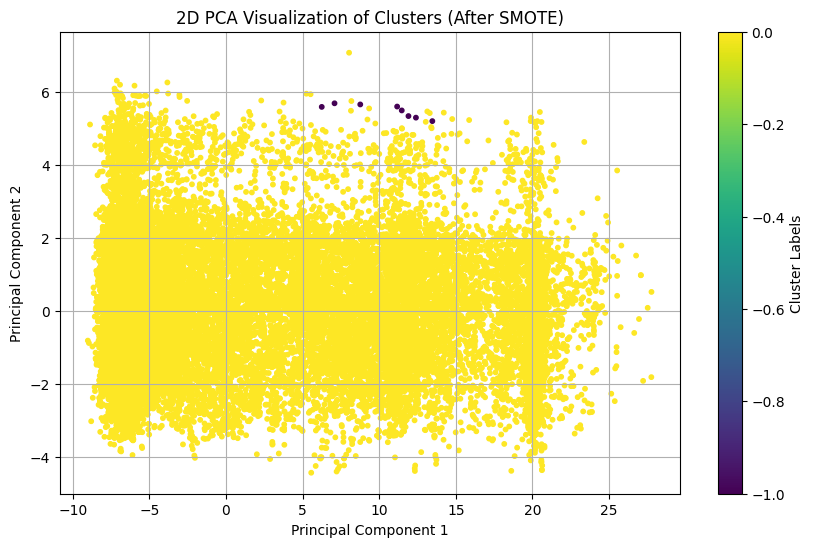

In [64]:
# Perform PCA on the SMOTE-balanced data to reduce features to 2D
pca = PCA(n_components=10)
reduced_features = pca.fit_transform(data_balanced)

# Create a scatter plot for the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=cluster_labels,  # Cluster labels from OPTICS
    cmap='viridis',
    s=10
)
plt.colorbar(scatter, label="Cluster Labels")
plt.title("2D PCA Visualization of Clusters (After SMOTE)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [65]:
# Count the number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of Clusters: {n_clusters}")

Number of Clusters: 1


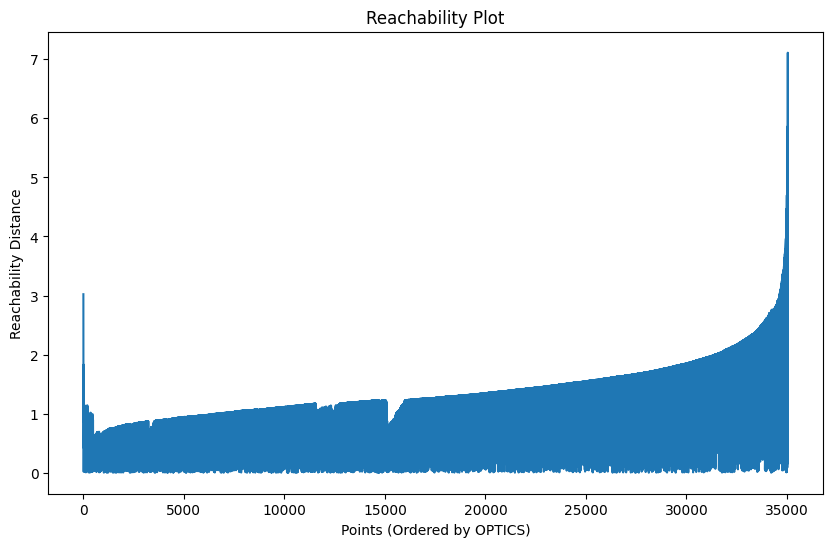

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(optics_model.reachability_[optics_model.ordering_])
plt.title('Reachability Plot')
plt.xlabel('Points (Ordered by OPTICS)')
plt.ylabel('Reachability Distance')
plt.show()


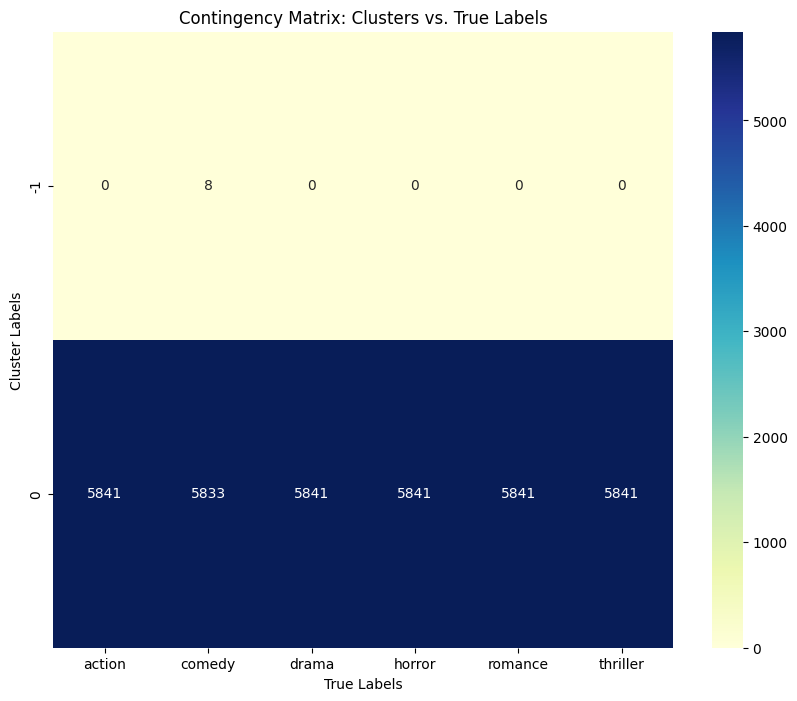

In [67]:
# Compute Adjusted Rand Index (ARI)
true_labels = data['Genre']  # Replace with true labels if available

# Generate the confusion matrix for cluster assignments vs. true labels
contingency_matrix = pd.crosstab(cluster_labels, true_labels_balanced)

# Create a heatmap to visualize the contingency matrix
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Contingency Matrix: Clusters vs. True Labels")
plt.xlabel("True Labels")
plt.ylabel("Cluster Labels")
plt.show()


In [68]:
# Compute the average distance to centroid for each cluster
avg_distances = (
    data_with_clusters[data_with_clusters['Cluster_Label'] != -1]
    .groupby('Cluster_Label')['Distance_To_Centroid']
    .mean()
)
print("Average Distance to Centroid for Each Cluster:")
print(avg_distances)

# Compute the average distance grouped by True Labels
avg_distance_by_true_label = (
    data_with_clusters.groupby(true_labels)['Distance_To_Centroid']
    .mean()
)
print("\nAverage Distance to Centroid Grouped by True Labels:")
print(avg_distance_by_true_label)

Average Distance to Centroid for Each Cluster:
Cluster_Label
0    12.65269
Name: Distance_To_Centroid, dtype: float64

Average Distance to Centroid Grouped by True Labels:
Genre
action      13.459101
comedy      13.554166
drama       14.218215
horror      15.179190
romance     13.208844
thriller    14.256487
Name: Distance_To_Centroid, dtype: float64


In [69]:
# Add distances to the contingency matrix
data_with_clusters['True_Label'] = true_labels_balanced.values
distance_contingency = data_with_clusters.pivot_table(
    index='Cluster_Label',
    columns='True_Label',
    values='Distance_To_Centroid',
    aggfunc=['mean', 'std', 'count']
)

In [70]:
# Display the contingency matrix with distances
print("\nContingency Matrix with Distance Statistics (Mean, Std, Count):")
print(distance_contingency)


Contingency Matrix with Distance Statistics (Mean, Std, Count):
                    mean                                             \
True_Label        action     comedy      drama    horror    romance   
Cluster_Label                                                         
 0             11.679334  13.010066  14.218215  13.27298  11.405993   
-1                   NaN        NaN        NaN       NaN        NaN   

                               std                                          \
True_Label      thriller    action    comedy     drama    horror   romance   
Cluster_Label                                                                
 0             12.330041  3.516919  3.780252  3.713069  4.858836  2.730979   
-1                   NaN       NaN       NaN       NaN       NaN       NaN   

                          count                                           
True_Label     thriller  action  comedy   drama  horror romance thriller  
Cluster_Label                         

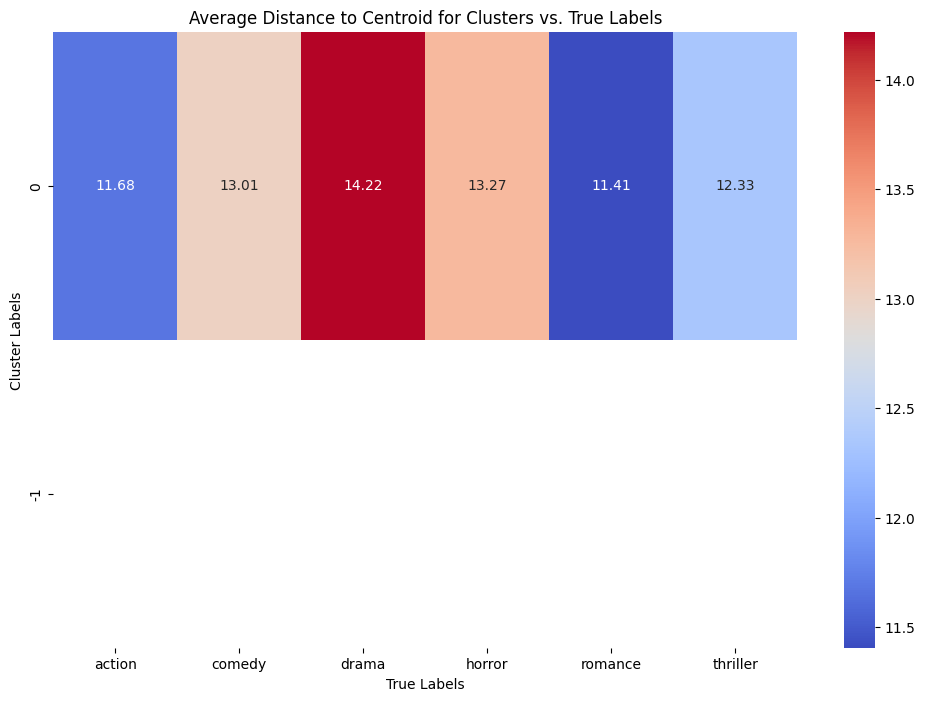

In [71]:
# Visualize the contingency matrix with average distances as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    distance_contingency['mean'], 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True
)
plt.title("Average Distance to Centroid for Clusters vs. True Labels")
plt.xlabel("True Labels")
plt.ylabel("Cluster Labels")
plt.show()

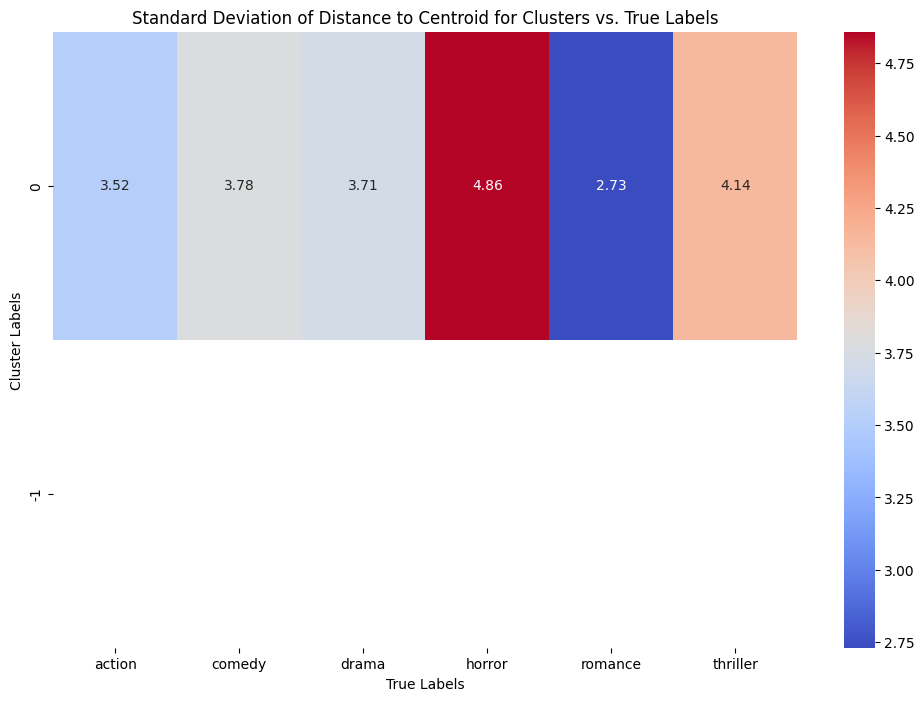

In [72]:
# Visualize the standard deviation of distances
plt.figure(figsize=(12, 8))
sns.heatmap(
    distance_contingency['std'], 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True
)
plt.title("Standard Deviation of Distance to Centroid for Clusters vs. True Labels")
plt.xlabel("True Labels")
plt.ylabel("Cluster Labels")
plt.show()

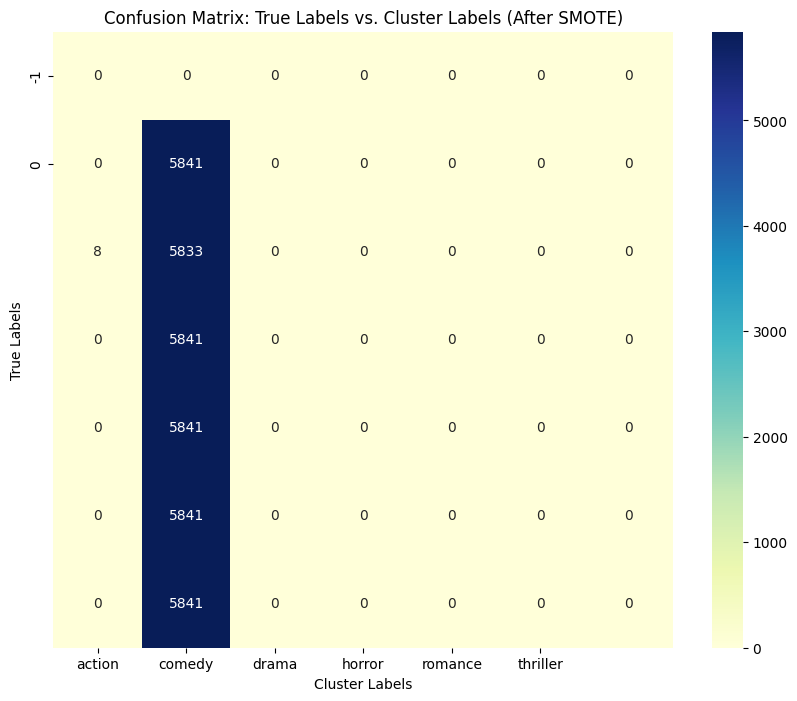

In [73]:
from sklearn.metrics import confusion_matrix

# Encode the SMOTE-balanced true labels to integers
label_encoder.fit(true_labels_balanced)
true_labels_balanced_encoded = label_encoder.transform(true_labels_balanced)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels_balanced_encoded, cluster_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=label_encoder.classes_,
    yticklabels=np.unique(cluster_labels),
    cbar=True
)
plt.title("Confusion Matrix: True Labels vs. Cluster Labels (After SMOTE)")
plt.xlabel("Cluster Labels")
plt.ylabel("True Labels")
plt.show()



In [74]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Calculate Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(true_labels_balanced, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

# Calculate Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(true_labels_balanced, cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

Adjusted Rand Index (ARI): 0.0000
Normalized Mutual Information (NMI): 0.0005
